<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import ipyparallel as ipp
from mpi4py import MPI

In [ ]:
# use on command line:
# ipcluster start -n 6

In [4]:
cluster = ipp.Client()
print('profile:', cluster.profile)
print("IDs:", cluster.ids) # Print process id numbers
%px import numpy as np

profile: default
IDs: [0, 1, 2, 3, 4, 5]


In [191]:
%%px

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# passing MPI datatypes explicitly
if rank == 0:
    data = np.arange(100, dtype='i')
    np.random.shuffle(data)
    comm.Send([data, MPI.INT], dest=1, tag=77)
    print("{} of {}: sent data to 1: {}".format(rank, size, data))
elif rank == 1:
    data = np.empty(100, dtype='i')
    comm.Recv([data, MPI.INT], source=0, tag=77)
    print("{} of {}: received data from 0: {}".format(rank, size, data))
else:
    print("{}: idle".format(rank))

[stdout:0] 
0 of 6: sent data to 1: [98 22 72 81 73 33 97 76 55 23 51 83 77  0 57 78  9 10  6 15 84 63 94 28
 27 86 90 42 66 31 59 41 82 29 50 79 16 69 34 20 99 24 52  1 91 88  3 25
 61 85  2 26  5 65 19 60 40 43 35 89 75 45 18 37 13 32 39 21 12 64 30 17
 46 71  8 74 53 47 48  7 49 67 87 14 54 56 38 96 80 70 92 62 11 95 36 44
 68  4 93 58]
[stdout:1] 
1 of 6: received data from 0: [98 22 72 81 73 33 97 76 55 23 51 83 77  0 57 78  9 10  6 15 84 63 94 28
 27 86 90 42 66 31 59 41 82 29 50 79 16 69 34 20 99 24 52  1 91 88  3 25
 61 85  2 26  5 65 19 60 40 43 35 89 75 45 18 37 13 32 39 21 12 64 30 17
 46 71  8 74 53 47 48  7 49 67 87 14 54 56 38 96 80 70 92 62 11 95 36 44
 68  4 93 58]
[stdout:2] 2: idle
[stdout:3] 3: idle
[stdout:4] 4: idle
[stdout:5] 5: idle


In [202]:
%%px
color = rank // 2 

In [203]:
%%px
new_comm = comm.Split(color, rank)

In [204]:
%%px
new_rank = new_comm.Get_rank()
new_size = new_comm.Get_size()
print("Color: {} / Local: {} of {} / Global: {} of {}".format(color, new_rank, new_size, rank, size))

[stdout:0] Color: 0 / Local: 0 of 2 / Global: 0 of 6
[stdout:1] Color: 0 / Local: 1 of 2 / Global: 1 of 6
[stdout:2] Color: 1 / Local: 0 of 2 / Global: 2 of 6
[stdout:3] Color: 1 / Local: 1 of 2 / Global: 3 of 6
[stdout:4] Color: 2 / Local: 0 of 2 / Global: 4 of 6
[stdout:5] Color: 2 / Local: 1 of 2 / Global: 5 of 6


In [200]:
from cubedspherepartitioner import CubedSpherePartitioner

In [ ]:
CubedSpherePartitioner

In [1]:
import numpy as np
import math

In [2]:
cube_neighbors = {1: {'U': [3, 3], 'D': [6, 0], 'L': [5, 1], 'R': [2, 0]},
                  2: {'U': [3, 0], 'D': [6, 3], 'L': [1, 0], 'R': [4, 1]},
                  3: {'U': [5, 3], 'D': [2, 0], 'L': [1, 1], 'R': [4, 0]},
                  4: {'U': [5, 0], 'D': [2, 3], 'L': [3, 0], 'R': [6, 1]},
                  5: {'U': [1, 3], 'D': [4, 0], 'L': [3, 1], 'R': [6, 0]},
                  6: {'U': [1, 0], 'D': [4, 3], 'L': [5, 0], 'R': [2, 1]}}

In [3]:
size = 24
ranks_per_tile = size // 6
my_tile = size // ranks_per_tile
ranks_per_axis = int(math.sqrt(ranks_per_tile))


In [4]:
tiles_placement = {i: (i // ranks_per_tile) + 1 for i in range(size)}

In [5]:
tiles_placement.items()

dict_items([(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 2), (7, 2), (8, 3), (9, 3), (10, 3), (11, 3), (12, 4), (13, 4), (14, 4), (15, 4), (16, 5), (17, 5), (18, 5), (19, 5), (20, 6), (21, 6), (22, 6), (23, 6)])

In [6]:
ranks_placement = dict()
for k, v in tiles_placement.items():
    ranks_placement.setdefault(v, list()).append(k)

In [7]:
ranks_placement

{1: [0, 1, 2, 3],
 2: [4, 5, 6, 7],
 3: [8, 9, 10, 11],
 4: [12, 13, 14, 15],
 5: [16, 17, 18, 19],
 6: [20, 21, 22, 23]}

In [8]:
tile_roots = {v: k[0] for v, k in ranks_placement.items()}

In [9]:
tile_roots

{1: 0, 2: 4, 3: 8, 4: 12, 5: 16, 6: 20}

In [10]:
assert cube_neighbors[1]['L'][0] == cube_neighbors[6]['L'][0] == cube_neighbors[4]['U'][0], 'Cube geometry faulty'
assert cube_neighbors[6]['D'][0] == cube_neighbors[2]['R'][0] == cube_neighbors[3]['R'][0], 'Cube geometry faulty' 
assert cube_neighbors[3]['U'][0] == cube_neighbors[6]['L'][0] == cube_neighbors[1]['L'][0], 'Cube geometry faulty'

In [11]:
for i in range(6):
    rotation_sum = 0
    [rotation_sum := rotation_sum + k[1] for v, k in cube_neighbors[i+1].items()]
    assert rotation_sum == 4, 'Cube geometry faulty' 


In [12]:
rotations = [0, 0, 1, 3, 3, 0]
rank_grid = np.asarray([np.rot90(np.flipud(np.asarray(ranks_placement[i+1]).reshape(ranks_per_axis, -1)), rotations[i]) for i in range(6)])

In [13]:
[[j for j in i.ravel()] for i in rank_grid]

[[2, 3, 0, 1],
 [6, 7, 4, 5],
 [11, 9, 10, 8],
 [12, 14, 13, 15],
 [16, 18, 17, 19],
 [22, 23, 20, 21]]

In [14]:
for i in rank_grid:
    print(i)

[[2 3]
 [0 1]]
[[6 7]
 [4 5]]
[[11  9]
 [10  8]]
[[12 14]
 [13 15]]
[[16 18]
 [17 19]]
[[22 23]
 [20 21]]


In [15]:
np.rot90(rank_grid[3],3)

array([[13, 12],
       [15, 14]])

In [16]:
m = np.array([[5, 0],
              [0, 5]])

In [17]:
np.rot90(m, 0)

array([[5, 0],
       [0, 5]])

In [18]:
np.rot90(m, -1)

array([[0, 5],
       [5, 0]])

In [19]:
np.rot90(m, 3)

array([[0, 5],
       [5, 0]])

In [20]:
x =  np.flipud(np.arange(4).reshape((2,-1)))

In [21]:
x

array([[2, 3],
       [0, 1]])

In [22]:
for i in range(4):
    print(np.rot90(x,i))

[[2 3]
 [0 1]]
[[3 1]
 [2 0]]
[[1 0]
 [3 2]]
[[0 2]
 [1 3]]


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

(-1.0, 2.0)

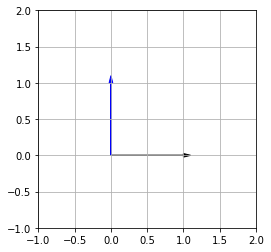

In [24]:

X = np.array((0))
Y = np.array((0))
E= np.array([[1, 0],
             [0, 1]])


fig, ax = plt.subplots()
q1 = ax.arrow(X, Y, E[0, 0], E[1, 0], head_width=0.05, head_length=0.1, fc='k', ec='k')
q2 = ax.arrow(X, Y, E[0, 1], E[1, 1], head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.grid()
ax.set_aspect('equal')

plt.xlim(-1,2)
plt.ylim(-1,2)

In [25]:
for i in range(4):
    E= np.array([[1, 0],
                 [0, 1]])
    E = np.matmul(rotate_90_deg[i], E)        
    print(E)
    fig, ax = plt.subplots()
    q1 = ax.arrow(X, Y, E[0, 0], E[1, 0], head_width=0.05, head_length=0.1, fc='r', ec='r')
    q2 = ax.arrow(X, Y, E[0, 1], E[1, 1], head_width=0.05, head_length=0.1, fc='b', ec='b')
    plt.grid()
    ax.set_aspect('equal')

    plt.xlim(-1,2)
    plt.ylim(-1,2)

NameError: name 'rotate_90_deg' is not defined

In [ ]:
rot_L = np.array([[0,-1],
                  [1, 0]])

In [27]:
rot_R = np.array([[ 0, 1],
                  [-1, 0]])

In [28]:
rotate_90_deg = np.asarray([ [[ 1, 0],
                        [ 0, 1]],
                       [[ 0, 1],
                        [-1, 0]],
                       [[-1, 0],
                        [ 0,-1]],
                       [[ 0,-1],
                        [ 1, 0]] ])

In [29]:
rotate_90_deg[1]

array([[ 0,  1],
       [-1,  0]])

In [30]:
def setup_grid(__num_ranks):

    for ranks_x in range(math.floor( math.sqrt(__num_ranks) ), 0, -1):
        if __num_ranks % ranks_x == 0:
            break
    __size = (__num_ranks // ranks_x, ranks_x)
    return __size

In [31]:
setup_grid()

TypeError: setup_grid() missing 1 required positional argument: '__num_ranks'

In [32]:
a,b = rank_grid[0],rank_grid

In [33]:
a

array([[2, 3],
       [0, 1]])

In [34]:
b

array([[[ 2,  3],
        [ 0,  1]],

       [[ 6,  7],
        [ 4,  5]],

       [[11,  9],
        [10,  8]],

       [[12, 14],
        [13, 15]],

       [[16, 18],
        [17, 19]],

       [[22, 23],
        [20, 21]]])

In [35]:
np.hstack((a,b,a))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [36]:
np.vstack((a,b))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

In [37]:
aaa = np.array([1,3,6])

In [38]:
rank_grid

array([[[ 2,  3],
        [ 0,  1]],

       [[ 6,  7],
        [ 4,  5]],

       [[11,  9],
        [10,  8]],

       [[12, 14],
        [13, 15]],

       [[16, 18],
        [17, 19]],

       [[22, 23],
        [20, 21]]])

In [39]:
left_right_grid = np.hstack((rank_grid[[4,0,1]]))
up_down_grid = np.vstack((rank_grid[[2, 0, 5]])) 

In [40]:
global_rank = 3
y_left_right_grid, x_left_right_grid = np.where(left_right_grid == global_rank)
y_up_down_grid, x_up_down_grid = np.where(up_down_grid == global_rank)

In [41]:
rank_neighbors = { 'U': up_down_grid[(y_up_down_grid-1, x_up_down_grid)].item(),
                   'D': up_down_grid[(y_up_down_grid+1, x_up_down_grid)].item(),
                   'L': left_right_grid[(y_left_right_grid, x_left_right_grid-1)].item(),
                   'R': left_right_grid[(y_left_right_grid, x_left_right_grid+1)].item()}

In [42]:
rank_neighbors.items()

dict_items([('U', 8), ('D', 1), ('L', 2), ('R', 6)])

In [43]:
rank_neighbors['U']

8

In [44]:
assert (2, 1) ==  np.where(up_down_grid == global_rank), \
    blub

In [46]:
[i for i in cube_neighbors[1]]

['U', 'D', 'L', 'R']

In [49]:
ttt = [cube_neighbors[1][d] for d in ['U', 'D', 'L', 'R']]

In [59]:
ttt

[[3, 3], [6, 0], [5, 1], [2, 0]]

In [61]:
ttt[0][0]

3

In [66]:
[k,v for k,v in cube_neighbors[1].items())]

SyntaxError: invalid syntax (<ipython-input-66-96604c4814a0>, line 1)

In [67]:
def __calculate_rank_grid(tile, tile2ranks, ranks_per_axis, rotation):
    return np.rot90(np.flipud(np.asarray(tile2ranks[tile]).reshape(ranks_per_axis, -1)), rotation)

In [73]:
__calculate_rank_grid(2, ranks_placement, 2, 3)

array([[4, 6],
       [5, 7]])

In [77]:
cube_neighbors[1].keys()

dict_keys(['U', 'D', 'L', 'R'])

In [93]:
tttt = {6: 9999}

In [94]:
for k,v in cube_neighbors[1].items():
    tttt[k]= v

In [95]:
tttt

{6: 9999, 'U': [3, 3], 'D': [6, 0], 'L': [5, 1], 'R': [2, 0]}

In [92]:
str(9)

'9'

In [97]:
tttt['U', 'D']

KeyError: ('U', 'D')

In [139]:
num_halo = 2
global_rank = 15
num_ranks = 24
ranks_per_tile = 4

In [172]:
def __rank_global2local():
        """Return local tile rank based on global rank, ranks per tile"""
        return global_rank % ranks_per_tile

In [176]:
local_rank = __rank_global2local()

In [177]:
local_rank

3

In [140]:
size = __setup_grid()

In [141]:
def __setup_grid():
        """Distribute ranks onto a Cartesian grid of workers"""
        for ranks_x in range(math.floor( math.sqrt(ranks_per_tile) ), 0, -1):
            if ranks_per_tile % ranks_x == 0:
                break
        return (ranks_per_tile // ranks_x, ranks_x)

In [150]:
def __rank_to_position(local_rank):
        """Find position of rank on worker grid"""
        # sanity check ---------
        # assert ( local_rank // size[1], local_rank % size[1] ) == np.where(rank_grid[tile] == global_rank), \
            # 'Check rank numbering consistency'
        # ----------------------
        return ( local_rank // size[1], local_rank % size[1] )

In [122]:
tile_neighbors = {1: {'U': [3, 1], 'D': [6, 0], 'L': [5, 3], 'R': [2, 0]},
                          2: {'U': [3, 0], 'D': [6, 1], 'L': [1, 0], 'R': [4, 3]},
                          3: {'U': [5, 1], 'D': [2, 0], 'L': [1, 3], 'R': [4, 0]},
                          4: {'U': [5, 0], 'D': [2, 1], 'L': [3, 0], 'R': [6, 3]},
                          5: {'U': [1, 1], 'D': [4, 0], 'L': [3, 3], 'R': [6, 0]},
                          6: {'U': [1, 0], 'D': [4, 1], 'L': [5, 0], 'R': [2, 3]}}

In [114]:
def __assign_ranks_tiles(num_ranks, ranks_per_tile):
        """Return dictionaries: rank->tile, tile->[ranks], tile->root rank"""
        
        rank2tile = {i: (i // ranks_per_tile) + 1 for i in range(num_ranks)} # 1-based tile numbering
        
        tile2ranks = dict()
        for k, v in rank2tile.items():
            tile2ranks.setdefault(v, list()).append(k)

        tile2root = {v: k[0] for v, k in tile2ranks.items()}

        return rank2tile, tile2ranks, tile2root

In [101]:
def __calculate_rank_grid(tile, tile2ranks, ranks_per_axis, rotation=0):
            """Return rotated array containing square grid of tile's global ranks"""
            return np.rot90(np.flipud(np.asarray(tile2ranks[tile]).reshape(ranks_per_axis, -1)), rotation)

In [124]:
def __assign_rank_grid(tile, tile2ranks, tile_neighbors, ranks_per_axis):
        """Return dictionary of arrays containing all neighboring tiles' placements of global ranks"""
        rank_grid = {tile: __calculate_rank_grid(tile, tile2ranks, ranks_per_axis)}
        for k, v in tile_neighbors[tile].items():
            rank_grid[k] = __calculate_rank_grid(v[0], tile2ranks, ranks_per_axis, v[1])
        return rank_grid

In [103]:
def __assign_rank_neighbors(global_rank, rank_grid, tile):
        """Return dictionary: global rank->global neighbor ranks"""
        up_down_grid = np.vstack((rank_grid['U'], rank_grid[tile], rank_grid['D']))
        left_right_grid = np.hstack((rank_grid['L'], rank_grid[tile], rank_grid['R'])) # tile numbering is 1-based

        y_up_down_grid, x_up_down_grid = np.where(up_down_grid == global_rank)
        y_left_right_grid, x_left_right_grid = np.where(left_right_grid == global_rank)
        
        return {'U': up_down_grid[(y_up_down_grid-1, x_up_down_grid)].item(),
                'D': up_down_grid[(y_up_down_grid+1, x_up_down_grid)].item(),
                'L': left_right_grid[(y_left_right_grid, x_left_right_grid-1)].item(),
                'R': left_right_grid[(y_left_right_grid, x_left_right_grid+1)].item()}

In [104]:
def __assign_ranks_tiles(num_ranks, ranks_per_tile):
        """Return dictionaries: rank->tile, tile->[ranks], tile->root rank"""
        
        rank2tile = {i: (i // ranks_per_tile) + 1 for i in range(num_ranks)} # 1-based tile numbering
        
        tile2ranks = dict()
        for k, v in rank2tile.items():
            tile2ranks.setdefault(v, list()).append(k)

        tile2root = {v: k[0] for v, k in tile2ranks.items()}

        return rank2tile, tile2ranks, tile2root

In [154]:
def __rank_global2local():
        """Return local tile rank based on global rank, ranks per tile"""
        return global_rank % ranks_per_tile

In [142]:
rank2tile,\
tile2ranks, \
tile2root = __assign_ranks_tiles(num_ranks, ranks_per_tile)

In [143]:
tile = rank2tile[global_rank] 

In [144]:
rank_grid = __assign_rank_grid(tile, tile2ranks, tile_neighbors, ranks_per_axis)

In [145]:
rank_grid

{4: array([[14, 15],
        [12, 13]]),
 'U': array([[18, 19],
        [16, 17]]),
 'D': array([[7, 5],
        [6, 4]]),
 'L': array([[10, 11],
        [ 8,  9]]),
 'R': array([[20, 22],
        [21, 23]])}

In [146]:
rank_neighbors = __assign_rank_neighbors(global_rank, rank_grid, tile)

In [147]:
rank_neighbors

{'U': 17, 'D': 13, 'L': 14, 'R': 20}

In [156]:
__rank_to_position(__rank_global2local())

(1, 1)

In [160]:
np.where(global_rank == rank_grid[tile])

(array([0]), array([1]))

In [159]:
rank_grid[tile]

array([[14, 15],
       [12, 13]])

In [164]:
nx = 512
ny = 512
nz = 32
domain = [nz, ny, nx]

In [170]:
def __setup_domain(shape, num_halo):
        """Distribute the points of the computational grid onto the Cartesian grid of workers"""
        assert len(shape) == 3, "Must pass a 3-dimensional shape"
        size_z = shape[0]
        size_y = __distribute_to_bins(shape[1], size[0])
        size_x = __distribute_to_bins(shape[2], size[1])

        pos_y = __cumsum(size_y, initial_value=num_halo)
        pos_x = __cumsum(size_x, initial_value=num_halo)

        domains = []
        shapes = []
        for rank in range(ranks_per_tile):
            pos = __rank_to_position(rank)
            domains += [[ pos_y[pos[0]] - num_halo, pos_x[pos[1]] - num_halo, \
                          pos_y[pos[0] + 1] + num_halo, pos_x[pos[1] + 1] + num_halo ]]
            shapes += [[ size_z, domains[rank][2] - domains[rank][0], \
                                 domains[rank][3] - domains[rank][1] ]]
        
        
        domain, shape = domains[local_rank], shapes[local_rank]
        max_shape = __find_max_shape(shapes)

        return domains, shapes, domain, shape, max_shape

In [179]:
def __distribute_to_bins(number, bins):
    """Distribute a number of elements to a number of bins"""
    n = number // bins
    bin_size = [n] * bins
    # make bins in the middle slightly larger
    extend = number - n * bins
    if extend > 0:
        start_extend = bins // 2 - extend // 2
        bin_size[start_extend:start_extend + extend] = \
            [ n + 1 for n in bin_size[start_extend:start_extend + extend] ]
    return bin_size

    
def __cumsum(array, initial_value=0):
    """Cumulative sum with an optional initial value (default is zero)"""
    cumsum = [initial_value]
    for i in array:
        cumsum += [ cumsum[-1] + i ]
    return cumsum

def __find_max_shape(shapes):
    max_shape = shapes[0]
    for shape in shapes[1:]:
        max_shape = list(map(max, zip(max_shape, shape)))
    return max_shape

In [180]:
domains, shapes, domain, shape, max_shape = __setup_domain(domain, num_halo)

In [181]:
domains

[[0, 0, 260, 260],
 [0, 256, 260, 516],
 [256, 0, 516, 260],
 [256, 256, 516, 516]]

In [182]:
domain

[256, 256, 516, 516]

In [183]:
shape

[32, 260, 260]

In [184]:
max_shape

[32, 260, 260]

In [185]:
tile

4

In [208]:
-1 in tile2ranks[tile]+[-1]

True

In [209]:
tile2ranks[tile]+[-1]

[12, 13, 14, 15, -1, -1]

In [212]:
tile2ranks[1]+[-1]

[0, 1, 2, 3, -1]